In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import tarfile
from six.moves import urllib
from tensorflow.keras.utils import to_categorical

tf.enable_eager_execution()

In [2]:
from tensorflow.keras.applications import MobileNet, Xception, ResNet50

In [3]:
img_size = 224  ## MobileNet, ResNet50
#img_size = 299 ## xception
conv_base = MobileNet(weights='imagenet', include_top=False,
                     input_shape=(img_size, img_size, 3))
#conv_base = Xception(weights='imagenet', include_top=False,
#                     input_shape=(img_size, img_size, 3))
#conv_base = ResNet50(weights='imagenet', include_top=False,
#                 input_shape=(img_size, img_size, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [5]:
conv_base.trainable

True

In [6]:
learning_rate = 0.001
training_epochs = 20
batch_size = 16

In [7]:
## MNIST Dataset #########################################################
#mnist = keras.datasets.mnist
#class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
##########################################################################

## Fashion MNIST Dataset #################################################
#mnist = keras.datasets.fashion_mnist
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
##########################################################################

## Cifar10 Dataset #########################################################
cifar = keras.datasets.cifar10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
############################################################################

In [8]:
#(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
(train_images, train_labels), (test_images, test_labels) = cifar.load_data()
    
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.

print(train_images.shape)
print(test_images.shape)

train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)    
    
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
                buffer_size=100000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


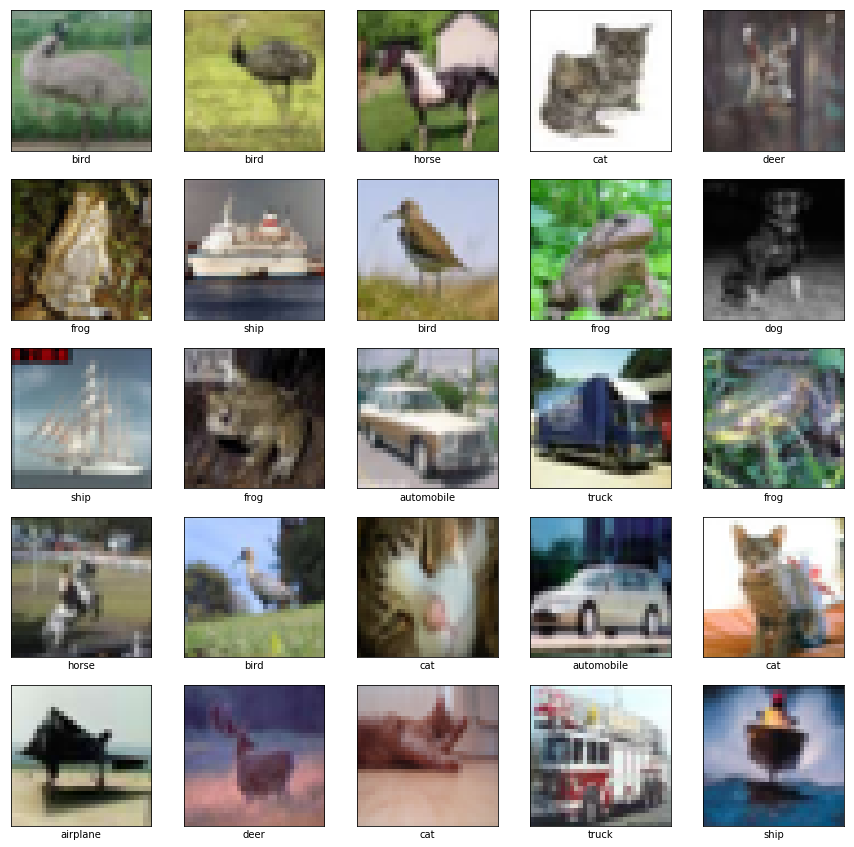

In [9]:
plt.figure(figsize=(15,15))
for i in range(25):
    img_idx = np.random.randint(0, 49999)
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[img_idx])
    plt.xlabel(class_names[np.argmax(train_labels[img_idx])])

In [10]:
def create_model():
    model = keras.models.Sequential()
    model.add(conv_base)
    model.add(keras.layers.GlobalAvgPool2D())
    model.add(keras.layers.Dense(128, activation=tf.nn.relu))
    model.add(keras.layers.Dense(10))

In [11]:
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               131200    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 3,361,354
Trainable params: 3,339,466
Non-trainable params: 21,888
_________________________________________________________________


In [12]:
def loss_fn(model, images, labels):
    logits = model(images, training=True)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
            logits=logits, labels=labels))    
    return loss  

In [13]:
def grad(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    return tape.gradient(loss, model.variables)

In [14]:
def evaluate(model, images, labels):
    logits = model(images, training=False)
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

In [15]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [16]:
# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_loss = 0.
    avg_train_acc = 0.
    avg_test_acc = 0.
    train_step = 0
    test_step = 0
    
    for images, labels in train_dataset:
        images = tf.image.resize(images, (img_size, img_size))                
        grads = grad(model, images, labels)                
        optimizer.apply_gradients(zip(grads, model.variables))
        loss = loss_fn(model, images, labels)
        acc = evaluate(model, images, labels)
        avg_loss = avg_loss + loss
        avg_train_acc = avg_train_acc + acc
        train_step += 1
    avg_loss = avg_loss / train_step
    avg_train_acc = avg_train_acc / train_step
    
    for images, labels in test_dataset:
        images = tf.image.resize(images, (img_size, img_size))
        acc = evaluate(model, images, labels)        
        avg_test_acc = avg_test_acc + acc
        test_step += 1    
    avg_test_acc = avg_test_acc / test_step    

    print('Epoch:', '{}'.format(epoch + 1), 'loss =', '{:.8f}'.format(avg_loss), 
          'train accuracy = ', '{:.4f}'.format(avg_train_acc), 
          'test accuracy = ', '{:.4f}'.format(avg_test_acc))

print('Learning Finished!')

Learning started. It takes sometime.
Epoch: 1 loss = 0.38928181 train accuracy =  0.8079 test accuracy =  0.8384
Epoch: 2 loss = 0.25140241 train accuracy =  0.9044 test accuracy =  0.8564
Epoch: 3 loss = 0.18095253 train accuracy =  0.9327 test accuracy =  0.8740
Epoch: 4 loss = 0.13175981 train accuracy =  0.9529 test accuracy =  0.9034
Epoch: 5 loss = 0.09620816 train accuracy =  0.9659 test accuracy =  0.8999
Epoch: 6 loss = 0.07283866 train accuracy =  0.9754 test accuracy =  0.9136
Epoch: 7 loss = 0.05388826 train accuracy =  0.9815 test accuracy =  0.9179
Epoch: 8 loss = 0.03940013 train accuracy =  0.9868 test accuracy =  0.9129
Epoch: 9 loss = 0.03018151 train accuracy =  0.9902 test accuracy =  0.9188
Epoch: 10 loss = 0.02619245 train accuracy =  0.9904 test accuracy =  0.9180
Epoch: 11 loss = 0.02032831 train accuracy =  0.9936 test accuracy =  0.9235
Epoch: 12 loss = 0.01629752 train accuracy =  0.9942 test accuracy =  0.9169
Epoch: 13 loss = 0.01505420 train accuracy =  0.